In [1]:
#Create Necessary Directories

import os

base_dir = '/Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing'
dataset_dir = os.path.join(base_dir, 'datasets')
os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(os.path.join(dataset_dir, 'images/train'), exist_ok=True)
os.makedirs(os.path.join(dataset_dir, 'images/val'), exist_ok=True)
os.makedirs(os.path.join(dataset_dir, 'images/test'), exist_ok=True)
os.makedirs(os.path.join(dataset_dir, 'labels/train'), exist_ok=True)
os.makedirs(os.path.join(dataset_dir, 'labels/val'), exist_ok=True)
os.makedirs(os.path.join(dataset_dir, 'labels/test'), exist_ok=True)


In [2]:
#Split Data into Train, Validate, Test Sets
from sklearn.model_selection import train_test_split
import pandas as pd
import shutil

# Load the cleaned data
df = pd.read_csv(os.path.join(base_dir, 'cleaned_data.csv'))

# Split data into train+val and test
train_val, test = train_test_split(df, test_size=0.1, random_state=42)

# Split train+val into train and val
train, val = train_test_split(train_val, test_size=0.11, random_state=42)  # 0.11 x 0.9 ≈ 0.1 of the original data

# Function to copy files into the right directories
def copy_files(df, split_type):
    for _, row in df.iterrows():
        source_path = os.path.join(base_dir, 'noise_removed', row['filename'])
        dest_path = os.path.join(dataset_dir, f'images/{split_type}', row['filename'])
        shutil.copy(source_path, dest_path)

copy_files(train, 'train')
copy_files(val, 'val')
copy_files(test, 'test')


FileNotFoundError: [Errno 2] No such file or directory: '/Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/cleaned_data.csv'

In [ ]:
#Create Label Files

# Assuming the fixed image size (320X320) for normalization
image_width, image_height = 416, 416

# Function to create label files
def create_label_files(df, split_type):
    for _, row in df.iterrows():
        label_path = os.path.join(dataset_dir, f'labels/{split_type}', row['filename'].replace('.jpg', '.txt'))
        class_index = int(row['quantity'])  # Class index from 'quantity' column
        # Simulating bounding box as a central portion of each image
        x_center = 0.5
        y_center = 0.5
        width = 0.98
        height = 0.98

        # Writing normalized bounding box coordinates to the label file
        with open(label_path, 'w') as file:
            file.write(f"{class_index} {x_center} {y_center} {width} {height}\n")

# Create label files for each dataset split
create_label_files(train, 'train')
create_label_files(val, 'val')
create_label_files(test, 'test')


In [ ]:
import os

def verify_quantity_counts(label_dir):
    quantity_counts = {}

    # Iterate over all label files in the directory
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(label_dir, label_file), 'r') as file:
                lines = file.readlines()
                for line in lines:
                    class_index = int(line.split()[0])  # Assuming the first entry is the class index
                    if class_index in quantity_counts:
                        quantity_counts[class_index] += 1
                    else:
                        quantity_counts[class_index] = 1

    return quantity_counts

# Example usage: Count quantities in the training labels
train_label_dir = os.path.join(dataset_dir, 'labels/train')
train_quantity_counts = verify_quantity_counts(train_label_dir)
print("Training set quantity counts:", train_quantity_counts)

# Count quantities in the validation labels
val_label_dir = os.path.join(dataset_dir, 'labels/val')
val_quantity_counts = verify_quantity_counts(val_label_dir)
print("Validation set quantity counts:", val_quantity_counts)

# Count quantities in the test labels
test_label_dir = os.path.join(dataset_dir, 'labels/test')
test_quantity_counts = verify_quantity_counts(test_label_dir)
print("Test set quantity counts:", test_quantity_counts)


Training set quantity counts: {1: 1278, 4: 1618, 3: 1605, 5: 1590, 0: 312, 2: 1607}
Validation set quantity counts: {5: 205, 4: 182, 1: 169, 3: 216, 2: 185, 0: 33}
Test set quantity counts: {5: 205, 2: 208, 1: 168, 4: 200, 0: 40, 3: 179}


In [ ]:
#Configure the Training Environment
yaml_content = f"""
train: {os.path.join(dataset_dir, 'images/train')}
val: {os.path.join(dataset_dir, 'images/val')}
test: {os.path.join(dataset_dir, 'images/test')}  # Adding test path

nc: 6  # number of classes
names: ['Quantity 0', 'Quantity 1', 'Quantity 2', 'Quantity 3', 'Quantity 4', 'Quantity 5']  # class names
"""

with open(os.path.join(dataset_dir, 'data.yaml'), 'w') as yaml_file:
    yaml_file.write(yaml_content)


In [ ]:
#Start the Training Process

# Navigate to your YOLOv5 directory
%cd /Users/priyasuresh/DataAnalyticProcess/yolov5

# Train the model
!python train.py --img 320 --batch 12 --epochs 20 --data '/Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets/data.yaml' --weights yolov5s.pt --cache


/Users/priyasuresh/DataAnalyticProcess/yolov5


/Users/priyasuresh/.pyenv/versions/3.10.4/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


train: weights=yolov5s.pt, cfg=, data=/Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=12, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-306-gb599ae42 Python-3.10.4 torch-2.3.0 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=

In [ ]:
#validation on the model
# Navigate to your YOLOv5 directory
%cd /Users/priyasuresh/DataAnalyticProcess/yolov5

# Run the validation command ensuring the file path is correctly quoted
!python val.py --weights "runs/train/exp8/weights/best.pt" \
               --data "/Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets/data.yaml" \
               --img 320 \
               --iou-thres 0.50 \
               --conf-thres 0.05 \
               --device cpu \
               --task val \
               --verbose


/Users/priyasuresh/DataAnalyticProcess/yolov5
val: data=/Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets/data.yaml, weights=['runs/train/exp8/weights/best.pt'], batch_size=32, imgsz=320, conf_thres=0.05, iou_thres=0.5, max_det=300, task=val, device=cpu, workers=8, single_cls=False, augment=False, verbose=True, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.05 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-306-gb599ae42 Python-3.10.4 torch-2.3.0 CPU

Fusing layers... 
Model summary: 157 layers, 7026307 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2
                 Class     Images  Instances          P          R      mAP50   
                   all        990        990       0.38      0.828      0.527      0

In [ ]:
#testing the test data for model's performance

# Navigate to your YOLOv5 directory
%cd /Users/priyasuresh/DataAnalyticProcess/yolov5

# Run the test using the best model weights and ensure the file path is correctly quoted
!python val.py --weights "runs/train/exp8/weights/best.pt" \
               --data "/Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets/data.yaml" \
              --img 320 \
              --iou-thres 0.50 \
              --conf-thres 0.05 \
              --device cpu \
              --task test \
              --verbose \
              --save-txt \
              --save-conf

/Users/priyasuresh/DataAnalyticProcess/yolov5
val: data=/Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets/data.yaml, weights=['runs/train/exp8/weights/best.pt'], batch_size=32, imgsz=320, conf_thres=0.05, iou_thres=0.5, max_det=300, task=test, device=cpu, workers=8, single_cls=False, augment=False, verbose=True, save_txt=True, save_hybrid=False, save_conf=True, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.05 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-306-gb599ae42 Python-3.10.4 torch-2.3.0 CPU

Fusing layers... 
Model summary: 157 layers, 7026307 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING
test: New cache created: /Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets/labe

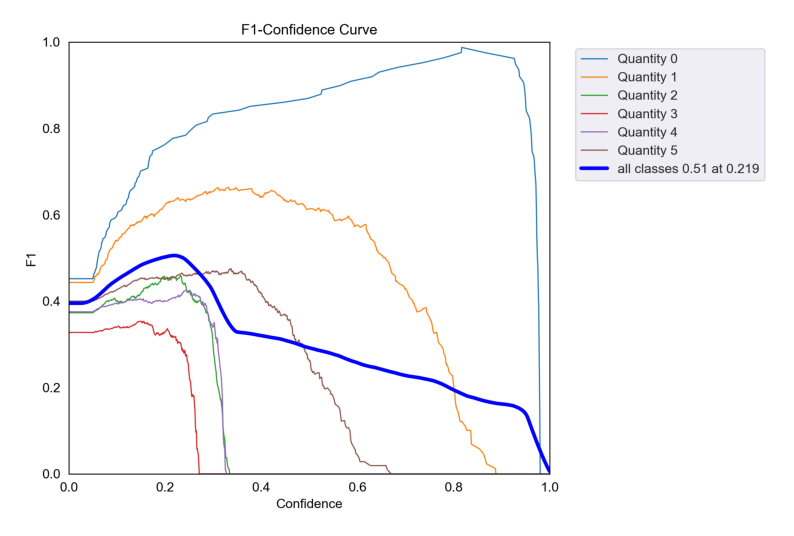

In [ ]:
###This plot visualizes the F1 score as a function of different confidence thresholds.
###The F1 score is a harmonic mean of precision and recall, and it's a useful metric for evaluating the accuracy of a classifier.

from PIL import Image
import matplotlib.pyplot as plt

# Load an image
image_path = '/Users/priyasuresh/DataAnalyticProcess/yolov5/runs/val/exp14/F1_curve.png'  # Update this to the path of the image you want to view
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(10, 10))  # Set the figure size as desired
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


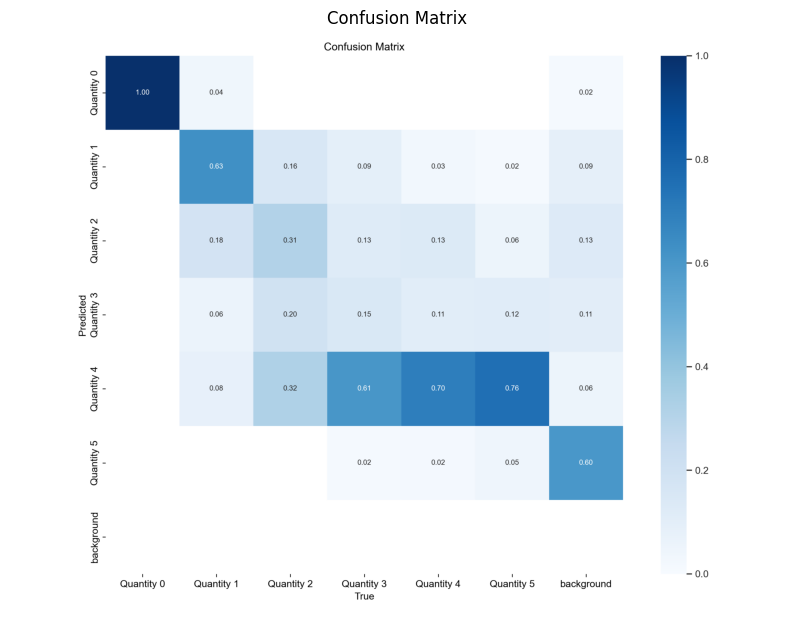

In [ ]:
#displaying the confusion matrix

confusion_matrix_path = '/Users/priyasuresh/DataAnalyticProcess/yolov5/runs/val/exp14/confusion_matrix.png'
conf_matrix_image = Image.open(confusion_matrix_path)

plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix_image)
plt.axis('off')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#new training the model with  50 epochs

In [ ]:
# Navigate to your YOLOv5 directory
%cd /Users/priyasuresh/DataAnalyticProcess/yolov5

# Train the model for 50 epochs using the smaller model for potentially better generalization
!python train.py --img 320 --batch 12 --epochs 50 --data '/Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets/data.yaml' --weights yolov5s.pt --cache


/Users/priyasuresh/DataAnalyticProcess/yolov5
train: weights=yolov5s.pt, cfg=, data=/Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=12, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-306-gb599ae42 Python-3.10.4 torch-2.3.0 CPU

hyperparameters: lr0

In [ ]:
#validation on the model
# Navigate to your YOLOv5 directory
%cd /Users/priyasuresh/DataAnalyticProcess/yolov5

# Run the validation command ensuring the file path is correctly quoted
!python val.py --weights "runs/train/exp15/weights/best.pt" \
               --data "/Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets/data.yaml" \
               --img 320 \
               --iou-thres 0.50 \
               --conf-thres 0.05 \
               --device cpu \
               --task val \
               --verbose


/Users/priyasuresh/DataAnalyticProcess/yolov5
val: data=/Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets/data.yaml, weights=['runs/train/exp15/weights/best.pt'], batch_size=32, imgsz=320, conf_thres=0.05, iou_thres=0.5, max_det=300, task=val, device=cpu, workers=8, single_cls=False, augment=False, verbose=True, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.05 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-306-gb599ae42 Python-3.10.4 torch-2.3.0 CPU

Fusing layers... 
Model summary: 157 layers, 7026307 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2
                 Class     Images  Instances          P          R      mAP50   
                   all        990        990       0.46       0.77      0.556      

In [ ]:
#testing the test data for model's performance

# Navigate to your YOLOv5 directory
%cd /Users/priyasuresh/DataAnalyticProcess/yolov5

# Run the test using the best model weights and ensure the file path is correctly quoted
!python val.py --weights "runs/train/exp15/weights/best.pt" \
               --data "/Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets/data.yaml" \
              --img 320 \
              --iou-thres 0.50 \
              --conf-thres 0.05 \
              --device cpu \
              --task test \
              --verbose \
              --save-txt \
              --save-conf

/Users/priyasuresh/DataAnalyticProcess/yolov5
val: data=/Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets/data.yaml, weights=['runs/train/exp15/weights/best.pt'], batch_size=32, imgsz=320, conf_thres=0.05, iou_thres=0.5, max_det=300, task=test, device=cpu, workers=8, single_cls=False, augment=False, verbose=True, save_txt=True, save_hybrid=False, save_conf=True, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.05 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-306-gb599ae42 Python-3.10.4 torch-2.3.0 CPU

Fusing layers... 
Model summary: 157 layers, 7026307 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING
                 Class     Images  Instances          P          R      mAP50   
                   all       1000       1000      0.448      0.797      0.554      0

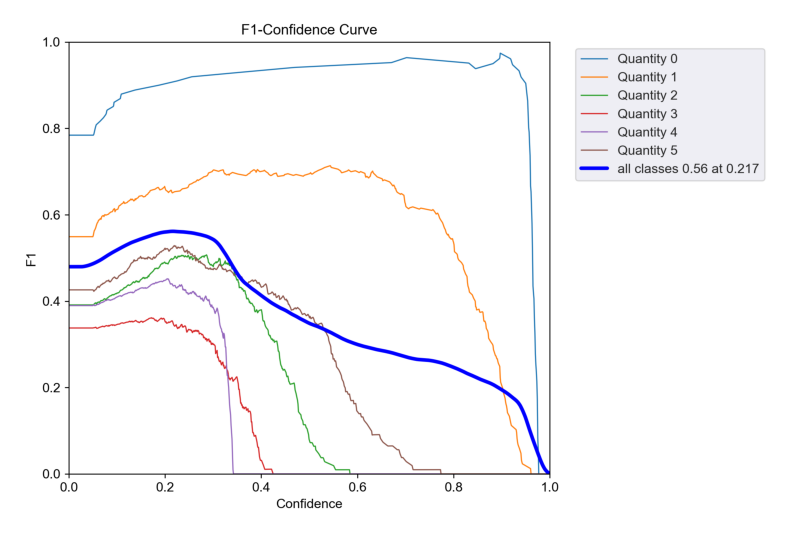

In [ ]:
###This plot visualizes the F1 score as a function of different confidence thresholds.
###The F1 score is a harmonic mean of precision and recall, and it's a useful metric for evaluating the accuracy of a classifier.

from PIL import Image
import matplotlib.pyplot as plt

# Load an image
image_path = '/Users/priyasuresh/DataAnalyticProcess/yolov5/runs/val/exp16/F1_curve.png'  # Update this to the path of the image you want to view
image = Image.open(image_path)

# Display the image
plt.figure(figsize=(10, 10))  # Set the figure size as desired
plt.imshow(image)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


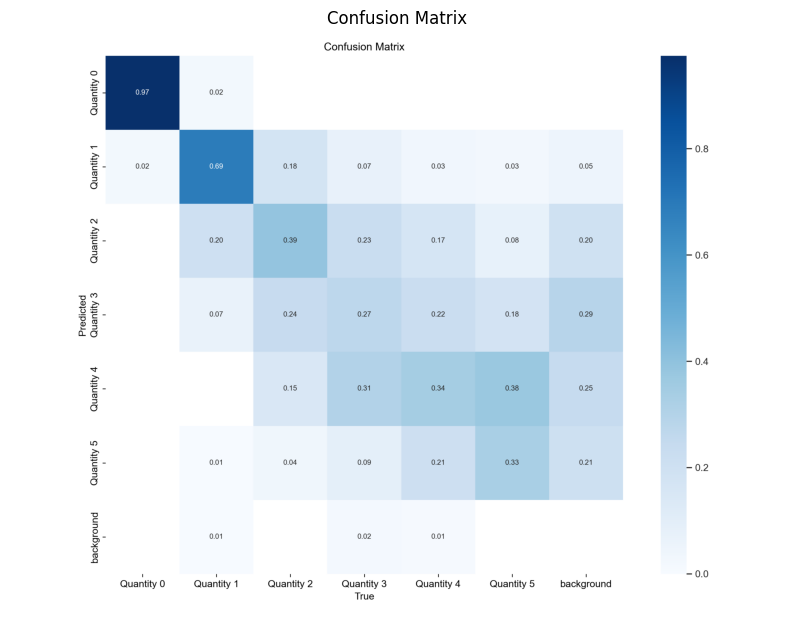

In [ ]:
#displaying the confusion matrix

confusion_matrix_path = '/Users/priyasuresh/DataAnalyticProcess/yolov5/runs/val/exp16/confusion_matrix.png'
conf_matrix_image = Image.open(confusion_matrix_path)

plt.figure(figsize=(10, 10))
plt.imshow(conf_matrix_image)
plt.axis('off')
plt.title('Confusion Matrix')
plt.show()


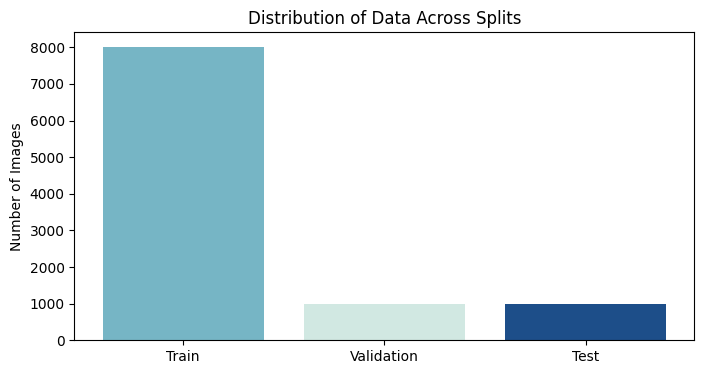

In [ ]:
#Visualize Data Splits

import matplotlib.pyplot as plt

# Data split counts
splits = ['Train', 'Validation', 'Test']
counts = [len(train), len(val), len(test)]

plt.figure(figsize=(8, 4))
plt.bar(splits, counts, color=['#76b5c5', '#d1e8e2', '#1d4e89'])
plt.title('Distribution of Data Across Splits')
plt.ylabel('Number of Images')
plt.show()


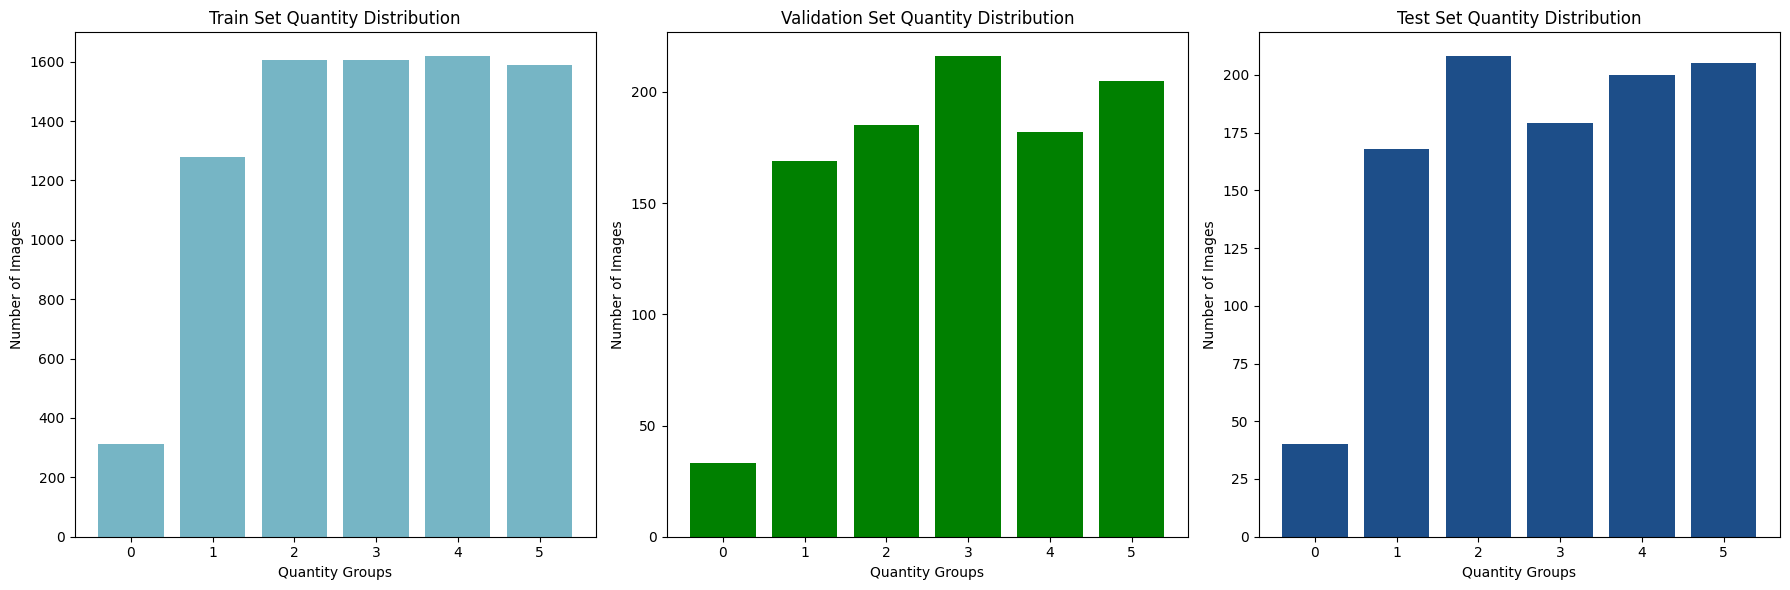

In [ ]:
#Visualize Quantity Distribution in Each Split
import numpy as np

def plot_quantity_distribution(data, title, color):
    quantities = data['quantity'].value_counts().sort_index()
    plt.bar(quantities.index, quantities.values, color=color)
    plt.title(title)
    plt.xlabel('Quantity Groups')
    plt.ylabel('Number of Images')
    plt.xticks(np.arange(0, 6))  # Assuming quantity groups from 0 to 5

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plot_quantity_distribution(train, 'Train Set Quantity Distribution', '#76b5c5')
plt.subplot(1, 3, 2)
plot_quantity_distribution(val, 'Validation Set Quantity Distribution', 'green')
plt.subplot(1, 3, 3)
plot_quantity_distribution(test, 'Test Set Quantity Distribution', '#1d4e89')
plt.tight_layout()
plt.show()


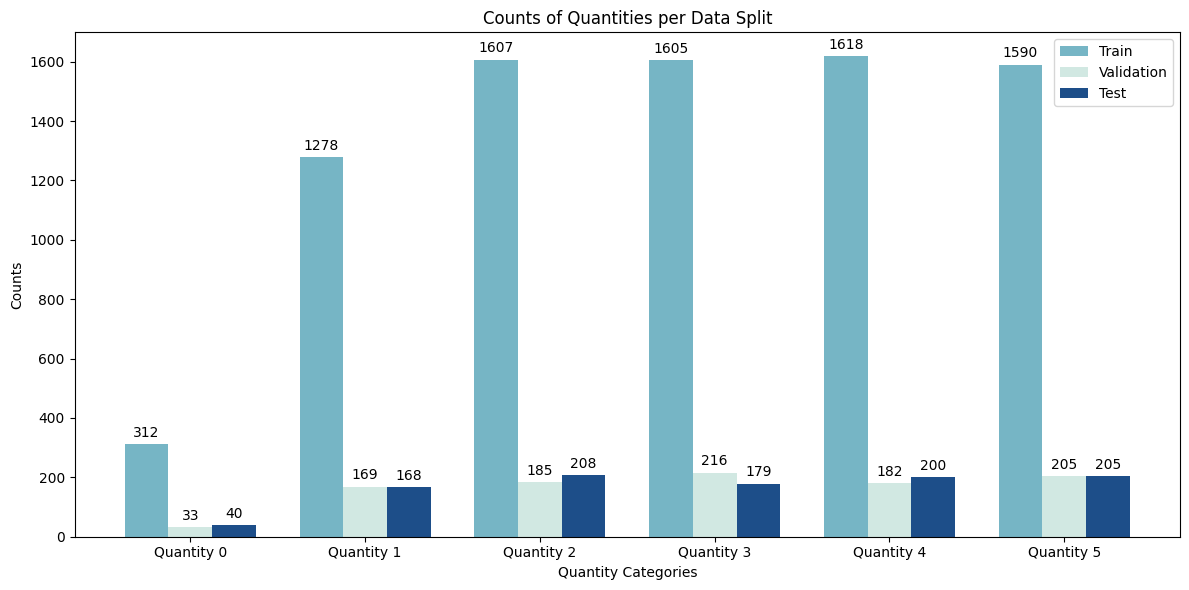

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'train_quantity_counts', 'val_quantity_counts', 'test_quantity_counts' are dictionaries
# containing the counts of each quantity class for the train, validation, and test sets respectively.
# Example: {0: 312, 1: 1278, 2: 1607, 3: 1605, 4: 1618, 5: 1590}

labels = ['Quantity 0', 'Quantity 1', 'Quantity 2', 'Quantity 3', 'Quantity 4', 'Quantity 5']
train_counts = [train_quantity_counts.get(i, 0) for i in range(6)]
val_counts = [val_quantity_counts.get(i, 0) for i in range(6)]
test_counts = [test_quantity_counts.get(i, 0) for i in range(6)]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, train_counts, width, label='Train', color='#76b5c5')
rects2 = ax.bar(x, val_counts, width, label='Validation', color='#d1e8e2')
rects3 = ax.bar(x + width, test_counts, width, label='Test', color='#1d4e89')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Quantity Categories')
ax.set_ylabel('Counts')
ax.set_title('Counts of Quantities per Data Split')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add labels on top of the bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()


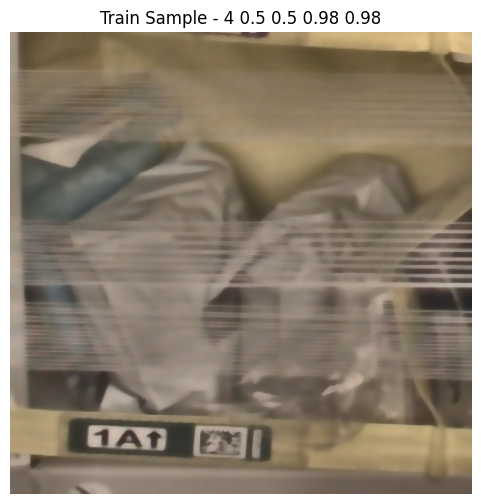

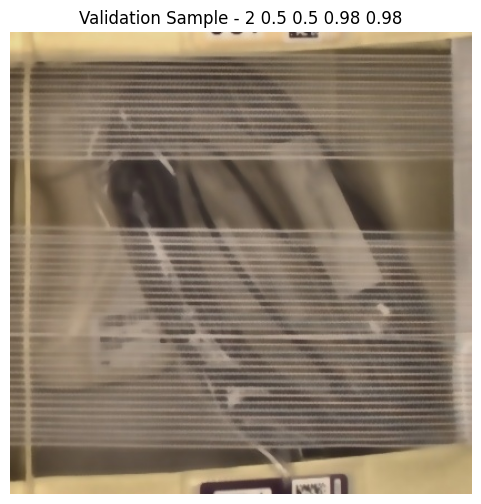

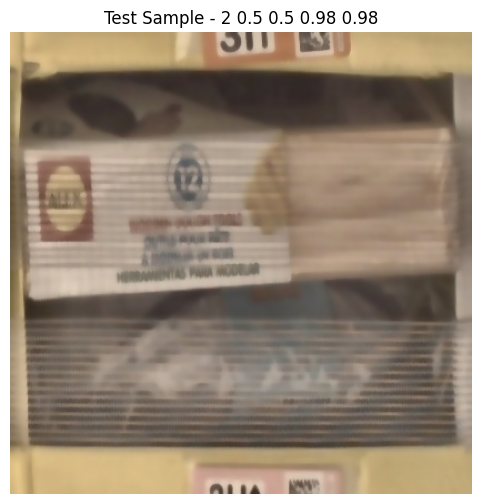

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def display_sample_image(image_dir, label_dir, title):
    # Get a list of image files in the directory
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    # Pick a random image file
    sample_image = random.choice(image_files)
    # Load the image
    img_path = os.path.join(image_dir, sample_image)
    img = Image.open(img_path)

    # Load the label
    label_path = os.path.join(label_dir, sample_image.replace('.jpg', '.txt'))
    with open(label_path, 'r') as file:
        label = file.read().strip()

    # Display the image and label
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f'{title} - {label}')
    plt.axis('off')
    plt.show()

# Assuming the directory paths set up in your previous messages
base_dir = '/Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets'
train_dir = os.path.join(base_dir, 'images/train')
train_label_dir = os.path.join(base_dir, 'labels/train')
val_dir = os.path.join(base_dir, 'images/val')
val_label_dir = os.path.join(base_dir, 'labels/val')
test_dir = os.path.join(base_dir, 'images/test')
test_label_dir = os.path.join(base_dir, 'labels/test')

# Display a sample from each split
display_sample_image(train_dir, train_label_dir, 'Train Sample')
display_sample_image(val_dir, val_label_dir, 'Validation Sample')
display_sample_image(test_dir, test_label_dir, 'Test Sample')


Displaying images with bounding boxes from train split:


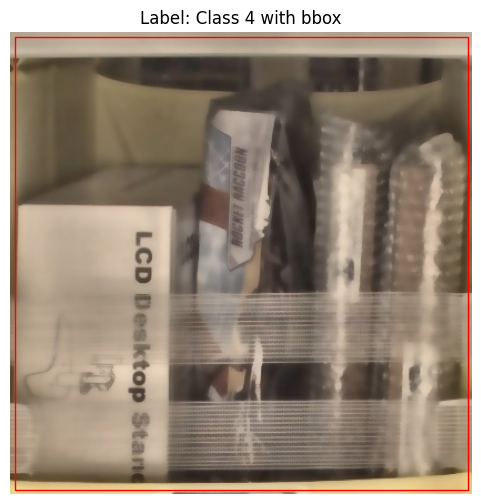

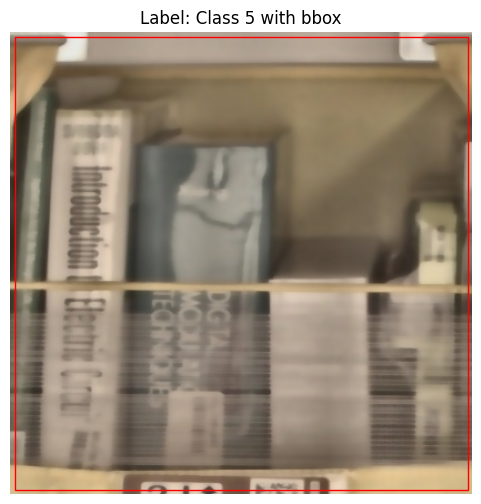

Displaying images with bounding boxes from val split:
Image 00055.jpg not found in /Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets/images/val
Image 00537.jpg not found in /Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets/images/val
Displaying images with bounding boxes from test split:
Image 00055.jpg not found in /Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets/images/test
Image 00537.jpg not found in /Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets/images/test


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

def display_image_with_bbox(image_dir, label_dir, filenames):
    for filename in filenames:
        # Load the image
        img_path = os.path.join(image_dir, filename)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.figure(figsize=(6, 6))
            ax = plt.gca()
            ax.imshow(img)
            plt.axis('off')

            # Load and display the label with bounding box
            label_path = os.path.join(label_dir, filename.replace('.jpg', '.txt'))
            if os.path.exists(label_path):
                with open(label_path, 'r') as file:
                    labels = file.readlines()

                for label in labels:
                    parts = label.strip().split()
                    class_index = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])

                    # Convert normalized coordinates to pixel coordinates
                    x_center *= img.width
                    y_center *= img.height
                    width *= img.width
                    height *= img.height

                    # Convert to matplotlib rectangle format
                    rect_x = x_center - width / 2
                    rect_y = y_center - height / 2

                    rect = patches.Rectangle((rect_x, rect_y), width, height, linewidth=1, edgecolor='r', facecolor='none')
                    ax.add_patch(rect)

                plt.title(f'Label: Class {class_index} with bbox')
            else:
                plt.title('Label file not found')

            plt.show()
        else:
            print(f"Image {filename} not found in {image_dir}")

# Directory paths
base_dir = '/Users/priyasuresh/Documents/Documents_Priya’s MacBook Pro/SPRING2024/Data 270- Data Analyst Process/Project_Data_preprocessing/datasets'
image_dirs = {
    'train': os.path.join(base_dir, 'images/train'),
    'val': os.path.join(base_dir, 'images/val'),
    'test': os.path.join(base_dir, 'images/test')
}
label_dirs = {
    'train': os.path.join(base_dir, 'labels/train'),
    'val': os.path.join(base_dir, 'labels/val'),
    'test': os.path.join(base_dir, 'labels/test')
}

# Filenames for bounding box display
filenames = [
    '00055.jpg',
    '00537.jpg'
]

# Display images with bounding boxes from each dataset split
for split, image_dir in image_dirs.items():
    print(f"Displaying images with bounding boxes from {split} split:")
    display_image_with_bbox(image_dir, label_dirs[split], filenames)
